# General libraries

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [436]:
from pymatgen.core import periodic_table
import pymatgen.io.cif as cif
import pymatgen.analysis.ewald as ewald

In [437]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Dataset normalization

In [438]:
df = pd.read_csv('Var_01.csv')
df.sample(2)

# all need is POSCAR as input for future engineernig
df.drop(['energy_per_atom', 'formation_energy_per_atom', 'volume', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 
 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 
 'icsd_id', 'icsd_ids',  'total_magnetization', 'material_id', 'oxide_type', 'tags', 'piezo', 'diel', 'full_formula'], axis='columns', inplace=True)
df.dropna(inplace=True)

In [439]:
# extract bulk moduli
df['bulk'] = df.elasticity.apply(lambda x: eval(x)['K_VRH'])
df

,energy,cif,elasticity,bulk
2,-15.580602,# generated using pymatgen\ndata_FeAg3\n_symme...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0
4,-11.293552,# generated using pymatgen\ndata_AlFe\n_symmet...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0
5,-41.981392,# generated using pymatgen\ndata_AlFe2\n_symme...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0
7,-64.628769,# generated using pymatgen\ndata_Al6Fe\n_symme...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0
9,-40.645991,# generated using pymatgen\ndata_Al3Fe\n_symme...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0
...,...,...,...,...
550,-49.071885,# generated using pymatgen\ndata_YFe5\n_symmet...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0
563,-25.278117,# generated using pymatgen\ndata_Zn13Fe\n_symm...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0
566,-51.810017,# generated using pymatgen\ndata_ZrFe2\n_symme...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0
568,-51.939510,# generated using pymatgen\ndata_Zr2Fe\n_symme...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0


In [440]:
# predicted value
pred_val = 'bulk'

---

# Data processing

In [441]:
def get_elem_props(elem):
    elem_props = {}
    elem_props['Z'] = periodic_table.Element(elem).Z
    elem_props['X'] = periodic_table.Element(elem).X
    elem_props['oxidation_states'] = periodic_table.Element(elem).oxidation_states
    elem_props['row'] = periodic_table.Element(elem).row
    elem_props['group'] = periodic_table.Element(elem).group
    elem_props['atomic_mass'] = periodic_table.Element(elem).atomic_mass
    elem_props['atomic_radius'] = periodic_table.Element(elem).atomic_radius
    elem_props['electrical_resistivity'] = periodic_table.Element(elem).electrical_resistivity
    elem_props['velocity_of_sound'] = periodic_table.Element(elem).velocity_of_sound
    elem_props['molar_volume'] = periodic_table.Element(elem).density_of_solid
    elem_props['thermal_conductivity'] = periodic_table.Element(elem).thermal_conductivity
    elem_props['melting_point'] = periodic_table.Element(elem).melting_point
    elem_props['average_ionic_radius'] = periodic_table.Element(elem).average_ionic_radius
    elem_props['average_cationic_radius'] = periodic_table.Element(elem).average_cationic_radius
    elem_props['average_anionic_radius'] = periodic_table.Element(elem).average_anionic_radius

    return elem_props

# Functions for the futures extracting

Extract pymatgen structure object from cif file as string

In [442]:
def get_struct(file_cif):
    imported_cif = cif.CifParser.from_string(file_cif) #; print(imported_cif)
    struct = imported_cif.get_structures()[0] #; print(struct)
    return struct

Function on Ewald summation as the convolutional layer for crystalline graph

$ E = \sum {\frac {F_1 \times F_2}{|r_i-r_j|}} $

In [443]:
def ewald_sum(struct):
    ew = ewald.EwaldSummation(struct, 
                         real_space_cut=None, 
                         recip_space_cut=None, 
                         eta=None, 
                         acc_factor=12.0, 
                         w=0.7071067811865475, 
                         compute_forces=False)
    
    return ew.total_energy

Charged structure is mandatory for Ewald summation procedure

We want to replace simple atomic oxidation states by another properties

In [444]:
def get_ox_dict(struct, prop):
    ox_dict={}
    for i in struct.species:
        try:
            ox_dict[str(i)] = round(get_elem_props(i)[prop])
        except Exception as e:
            ox_dict[str(i)] = np.nan
            print(e)
    return ox_dict

Then we need to get pymatgen.core.Structure obj. as the charged structure

In [445]:
def get_charged_struct(file_cif, ox_dict):
    imported_cif = cif.CifParser.from_string(file_cif)
    struct = imported_cif.get_structures()[0]
    try:
        struct.add_oxidation_state_by_element(ox_dict)
        return struct
    except Exception as e:
        print(e)
        return np.nan

Finally we can summarize previous functions to get a result of Ewald summation from one line of dataset

In [446]:
def get_ew(file_cif, p):
    struct = get_struct(file_cif)
    ox_dict = get_ox_dict(struct, p) #; print(ox_dict)
    charged_struct = get_charged_struct(file_cif, ox_dict) #; print(charged_struct)
    try:
        ew = ewald_sum(charged_struct) #; print(ew)
        return (ew*-1)
    except Exception as e:
        print(e)
        return np.nan

# Prepare raw futures

In [447]:
props = ['Z', 'X', 'row', 'group', 'atomic_mass', 'atomic_radius', 'thermal_conductivity', 'melting_point'] 

d = df.copy()

# instantiate progress
total = d.shape[0]

p_counter = 0
p_len = len(props) #; print(p_len)

for p in props:
    df_processed = pd.DataFrame()
    tmp = {}
    p_counter += 1
    progress = 0
    
    # cs corresponds to single cif as string
    for cs in d['cif']:
        f = get_ew(cs, p)
        tmp[p] = f
        df_processed = df_processed.append([tmp])
        
        # update progress
        progress += 1
        print(f'Property: {p_counter}/{p_len}, Progress: {progress}/{total} ', end='\r')
    
    d[p] = df_processed.values

d

C:\Users\79645\anaconda3\envs\Pymatgen\lib\site-packages\pymatgen\io\cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


,energy,cif,elasticity,bulk,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,-15.580602,# generated using pymatgen\ndata_FeAg3\n_symme...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,-11.293552,# generated using pymatgen\ndata_AlFe\n_symmet...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,-41.981392,# generated using pymatgen\ndata_AlFe2\n_symme...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,-64.628769,# generated using pymatgen\ndata_Al6Fe\n_symme...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,-40.645991,# generated using pymatgen\ndata_Al3Fe\n_symme...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
550,-49.071885,# generated using pymatgen\ndata_YFe5\n_symmet...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,-25.278117,# generated using pymatgen\ndata_Zn13Fe\n_symm...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,-51.810017,# generated using pymatgen\ndata_ZrFe2\n_symme...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,-51.939510,# generated using pymatgen\ndata_Zr2Fe\n_symme...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


---

# Prepare data for ML

## Futures vectors

In [487]:
X = d.drop([pred_val, 'cif', 'energy', 'elasticity'], axis='columns')
X

,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...
550,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


## Predicted values

In [449]:
y = d[pred_val].values.ravel()
print("The number of elements in the predicted value array ("+str(pred_val)+"):", str(y.shape[0]))

The number of elements in the predicted value array (bulk): 160


## Splitting into training and test samples

In [450]:
# Test samples fraction
test_size = 0.2

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("The ratio of the volumes of training/test samples: "+str(X_train.shape[0])+'/'+str(X_test.shape[0]))

The ratio of the volumes of training/test samples: 128/32


## Data normalization

In [452]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Check samples:")
X.shape, y.shape

Check samples:


((160, 8), (160,))

---

## Correlations analysis

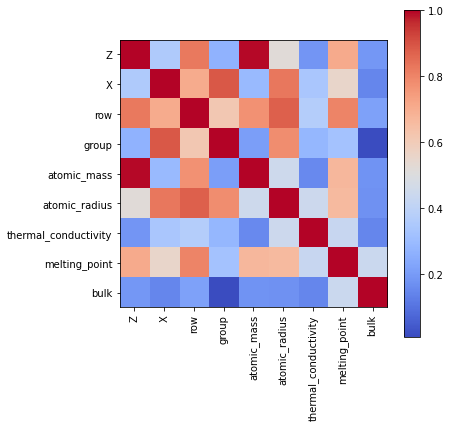

In [453]:
test_df = X.copy()
test_df[pred_val] = y
test_df

corr_matrix = test_df.corr()

plt.figure(figsize=(6,6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()  # add color intensity map

plt.xticks(rotation=90)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.show()

Диаграмма корреляций прогнозируемой величины с величинами из набора векторов признаков:

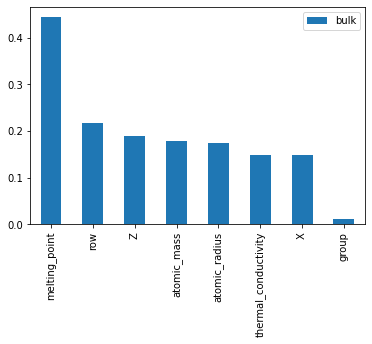

In [454]:
data_4_analysis = pd.DataFrame().append(X)
data_4_analysis[pred_val] = y

# bar plot
pd.DataFrame(data_4_analysis.corr()[pred_val]).\
             drop(index=[pred_val]).\
             sort_values(by=[pred_val], ascending=False).\
             plot(kind='bar')
plt.show()

---

# Regression models

Regression metric:

In [455]:
scoring='neg_mean_absolute_error'

*Other regression metrics from sklearn:*
- `explained_variance`
- `max_error`
- `neg_mean_absolute_error`
- `neg_mean_squared_error`
- `neg_root_mean_squared_error`
- `neg_mean_squared_log_error`
- `neg_median_absolute_error`
- `r2`
- `neg_mean_poisson_deviance`
- `neg_mean_gamma_deviance`
- `neg_mean_absolute_percentage_error`

In [456]:
res_table = pd.DataFrame()
tmp={}

## Linear regression

Cooresponding libraries

In [457]:
from sklearn.linear_model import LinearRegression

Функция построения графика $y_{pred}=f(y_{true})$ и отображения метрики $R^2$ в кросс-валидации:

In [458]:
def ex_plot(model_name, y_true, y_pred, scores):
    fig, ax = plt.subplots(figsize=(6,6))
    
    plt.plot(y_test, y_pred, 'o', label=str(scoring)+'(C-V) = '+str(round(scores,2)))
    
    max_dimension = max(y_test.max(), y_pred.max())
    min_dimension = min(y_test.min(), y_pred.min())
    
    x_line = [min_dimension, max_dimension]
    y_line = x_line
    
    plt.plot(x_line, y_line)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend()
    plt.title(model_name)
    
    plt.show()

---

Применение модели линейной регрессии:

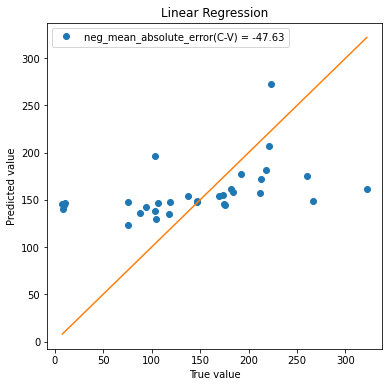

In [459]:
lr = LinearRegression()

''' MODEL FIT '''
lr.fit(X_train, y_train)
   
''' Cross-Validation '''
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=scoring)

''' PLOT '''
ex_plot('Linear Regression', y_test, lr.predict(X_test), scores.mean())

tmp['model'] = 'lr'
tmp[scoring] = scores.mean()
res_table = res_table.append([tmp])

---

## kNN

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'n_neighbors': 5}


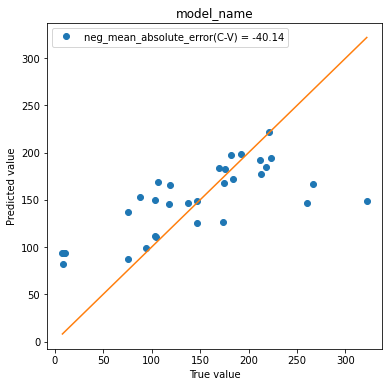

In [460]:
# Загрузка библиотек
from sklearn.neighbors import KNeighborsRegressor

# Инициализация модели МО:
model_knr = KNeighborsRegressor()

# Массив числа соседей для перебора
n_neighbors = np.arange(1,15,1) # from 1 to 10

# Определение сетки параметров
param_grid = {'n_neighbors': n_neighbors}

# Инициирование поиска по сетке параметров
gs = GridSearchCV(model_knr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

# Определение наилучшей параметризации
model_best = gs.best_estimator_ 
print(gs.best_params_)
ex_plot('model_name', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [461]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
knn_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'knn'
tmp[scoring] = knn_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## SVM

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'C': 1000, 'degree': 1, 'epsilon': 0.5, 'kernel': 'rbf', 'tol': 0.01}


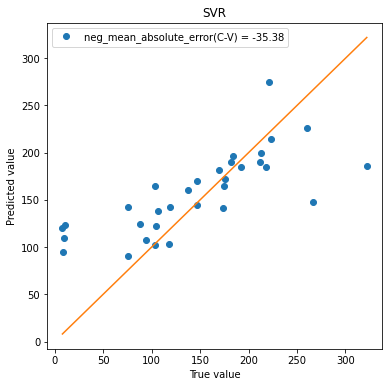

In [488]:
# Загрузка библиотек
from sklearn.svm import SVR

# Инициализация модели МО:
svr = SVR()

# Массив параметров для перебора
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1,2,3,5]
tol = [0.001, 0.01]
C = [100, 1000]
epsilon = [0.2, 0.3, 0.5]

param_grid = {'kernel': kernel, 'degree' : degree, 'tol' : tol, 'C' : C, 'epsilon' : epsilon}

gs = GridSearchCV(svr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('SVR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').max())

In [489]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
svm_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'svm'
tmp[scoring] = svm_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## RFR

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.001, 'n_estimators': 300}


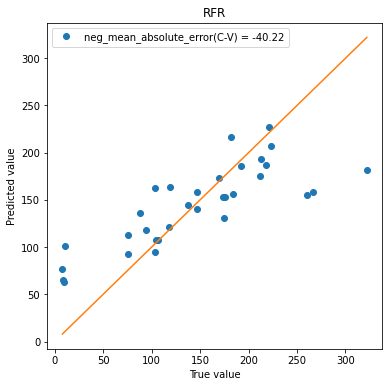

In [496]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()

n_estimators = [300,500]
max_features = ['auto']
max_depth = [1,40,100]
min_samples_split = [0.0001,0.001,0.01]
min_samples_leaf = [1,2]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(RFR, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('RFR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [497]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
rfr_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'rfr'
tmp[scoring] = rfr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## GBR

Fitting 5 folds for each of 108 candidates, totalling 540 fits
------------------------------
Параметры наилучшего варианта:
{'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 0.1, 'n_estimators': 350}


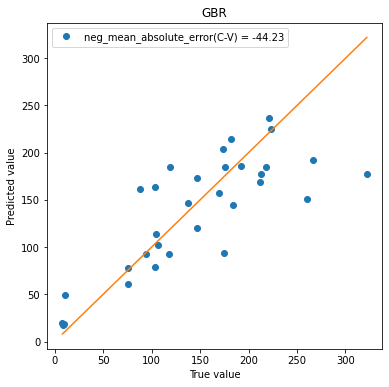

------------------------------


In [499]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

# Массивы значений параметров для поиска по сетке
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [300,350]
min_samples_split = [0.001,0.01, 0.1]
min_samples_leaf = [1,2]
max_depth = [1,5,15]

param_grid = { 'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}

gs = GridSearchCV(gbr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print("------------------------------")
print("Параметры наилучшего варианта:")
print(gs.best_params_)
ex_plot('GBR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())
print("------------------------------")

In [500]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
gbr_res = results.sort_values(by='rank').set_index('rank').head(3)

tmp['model'] = 'gbr'
tmp[scoring] = gbr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

## Simple regressors summary

In [501]:
# print(df.columns.values)
# res_table.r2.max()
res_table

,model,neg_mean_absolute_error
0,lr,-47.629478
0,knn,-38.471385
0,svm,-35.440345
0,rfr,-36.529129
0,svm,-35.379879
0,rfr,-36.511855
0,rfr,-36.143234
0,rfr,-36.284117
0,gbr,-38.910279


---

In [469]:
# # pre-requirements
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras import optimizers

# # keras-tuner (general)
# import tensorflow.keras as keras

# # hyperparameter optimization algorithm
# from kerastuner import Hyperband # OTHER MODULES: RandomSearch, BayesianOptimization

# # easy calling
# from kerastuner.engine.hypermodel import HyperModel
# from kerastuner.engine.hyperparameters import HyperParameters

In [470]:
# def build_model(hp):
    
#     ''' trial parameters '''
#     # model type selection
#     model = Sequential()
        
#     # model hyperparameters
#     activation_choice = hp.Choice('activation', values=['relu', 'sigmoid'])
#     optimizer_choice = hp.Choice('optimizer', values=['adam','rmsprop','SGD'])
#     hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 
    
#     ''' ANN STRUCTURE '''
#     # first h-layer
#     model.add(Dense(units=hp.Int('layer_1', min_value=20, max_value=200, step=20),
#                     input_dim=9,
#                     activation=activation_choice))
    
#     # other h-layer 
#     # optimized for perfomance
#     for i in range(hp.Int('num_layers', 2, 4)):
#         model.add(Dense(units=hp.Int('layer_' + str(i), min_value=20, max_value=100, step=20),
#                         activation=activation_choice))
    
#     # output layer
#     model.add(Dense(1))
    
#     ''' instantiate ANN '''
#     model.compile(optimizer=optimizer_choice,
#                   loss='MSE',
#                   metrics=['MSE'])
#     return model

In [471]:
# tuner = Hyperband(build_model,
#                   objective='val_MSE',
#                   max_epochs=500, # for Hyperband only
#                   #max_trials=20, # for BayesianOptimization & RandomSearch
#                   directory='test_dir') #, # ATTENTION! path should be latin!!!!!!
#                   #overwrite=True) # overwrite all previous models in specified directory

In [472]:
# tuner.search_space_summary()

In [473]:
# tuner.search(X_train, y_train, 
#              batch_size=200, # optimal batch size preselected
#              # epochs=500,   # for BayesianOptimization & RandomSearch
#              validation_split=0.2,
#              verbose=2)

In [474]:
# tuner.results_summary()

In [475]:
# models = tuner.get_best_models(num_models=3)

In [476]:
# m1 = models[0]
# m2 = models[1]
# m3 = models[2]
# # m1.fit(X_train, y_train)
# # m2.fit(X_train, y_train)
# # m3.fit(X_train, y_train)

In [477]:
# m1.summary()

In [478]:
# m2.summary()

In [479]:
# m3.summary()

In [480]:
# from sklearn.metrics import r2_score

# def get_X_y(df_test, df_train):    
#     X_train = df_train.copy().drop([pred_val], axis='columns')
#     y_train = pd.DataFrame(df_train[pred_val])
#     X_test = df_test.copy().drop([pred_val], axis='columns')
#     y_test = pd.DataFrame(df_test[pred_val])
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     return X_train, y_train, X_test, y_test
    
# def get_predictions(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train, epochs=100, verbose=2)
#     predicticted_values = model(X_test).numpy()
#     predicticted_values = predicticted_values.reshape(predicticted_values.shape[0]) 
#     R2 = r2_score(y_test, predicticted_values) 
#     return R2

In [481]:
# from ipywidgets import IntProgress
# from IPython.display import display

# from sklearn.model_selection import KFold

# # splits number for k-fold C-V
# n_splits = 5
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# # instantiate the bar
# progress_bar = IntProgress(min=0, max=n_splits)
# percentage = round(progress_bar.value*100/n_splits)
# display(progress_bar) # display the bar

# # temporary data for futher plotting
# hist = pd.DataFrame()
# tmp = {}

# for train, test in kf.split(df):
# #     new_model = m1
#     new_model = keras.models.load_model('best_model.h5')
#     df_train = df.iloc[train]
#     df_test = df.iloc[test]
#     X_train, y_train, X_test, y_test = get_X_y(df_test, df_train)
#     R2 = get_predictions(new_model, X_train, y_train, X_test, y_test)
#     tmp['Fold'] = progress_bar.value
#     tmp['R2'] = R2
#     hist = hist.append([tmp])
    
#     # progress bar update
#     progress_bar.value += 1
#     percentage = round(progress_bar.value*100/n_splits)
#     progress_bar.description = str(percentage)+" %"

# hist = hist.set_index(['Fold'])

In [502]:
# hist

In [483]:
# model = keras.models.load_model('best_model.h5')
# model.fit(X_train, y_train, epochs=200)
# predicticted_values = model(X_test).numpy()
# predicticted_values = predicticted_values.reshape(predicticted_values.shape[0])


In [484]:
# plt.plot(y_test, predicticted_values, 'bo')

In [485]:
# m1.save('best_model.h5')

In [486]:
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('best_model.h5')

# # Покажем архитектуру модели
# new_model.summary()

# plot_model_fit(new_model, X_test, y_test)